## Replicate topiramate butte paper

http://stm.sciencemag.org/content/3/96/96ra76.full

In [16]:
%matplotlib inline

In [4]:
import numpy as np
import dill
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import DDS

In [5]:
BASE = os.getcwd()
print(BASE)

/home/gstupp/projects/repositioning


In [6]:
#%% Parse GEO SOFT
df_GEO = DDS.parse_SOFT(os.path.join(BASE,"GDS1615/GDS1615.soft"))
df_GEO.to_csv(os.path.join(BASE,"GDS1615/df.csv"))

In [7]:
#%% get sample data relationship
sample_type = DDS.parse_SDRF(os.path.join(BASE,"GDS1615/E-GEOD-3365.sdrf.txt"))
df_crohn_normal = df_GEO[pd.Series(sorted(list(sample_type["Crohn's disease"] | sample_type["normal"])))]
DDS.write_SAM_csv(df_crohn_normal, sample_type["normal"], sample_type["Crohn's disease"], os.path.join(BASE,"GDS1615/df_crohn_normal.csv"))

In [9]:
# defines which samples are which type
print(sample_type.keys())

dict_keys(['ulcerative colitis', "Crohn's disease", 'normal'])


In [11]:
# sample which are crohn's or normal
df_crohn_normal.head()

GSM76056  GSM76057  GSM76058   GSM76059   GSM76060  GSM76061  \
IDENTIFIER                                                                 
DDR1         67.3570   89.2291   73.2114   92.02410   67.24400   60.2753   
RFC2         28.2760   29.7479   39.7308   28.47250   20.55360   19.0836   
HSPA6        24.7667   48.6979   38.2649   21.85540   32.76630   42.2426   
PAX8        321.0380  302.0000  283.4980  375.73600  231.54600  215.0580   
GUCA1A       18.0066   18.8705   19.5292    3.69764    9.69721   13.1813   

            GSM76062   GSM76063  GSM76064  GSM76065    ...     GSM76146  \
IDENTIFIER                                             ...                
DDR1        109.4580   79.37800   65.8434   64.8315    ...      81.5066   
RFC2         44.7917   24.38120   31.3879   32.1446    ...      23.3050   
HSPA6        43.4585   50.85160   37.2543   48.4966    ...      69.7936   
PAX8        371.8230  263.48700  228.4100  268.8280    ...     305.3720   
GUCA1A       23.7742    8.73234   10.0904   10.1528    ...      10.5157   

            GSM76147   GSM76148  GSM76149  GSM76150  GSM76151  GSM76152  \
IDENTIFIER                                                                
DDR1         73.6271   85.96740   80.1130   78.8843   84.5962   94.4346   
RFC2         16.2106   29.23900   24.1647   25.8544   32.9647   27.5230   
HSPA6        42.9856   36.32400   46.3443   50.3633   52.4422   67.6186   
PAX8        258.9720  203.77400  257.0410  254.7260  263.9610  352.4230   
GUCA1A        5.6607    8.85446   11.3323   10.9163   11.1546   12.3789   

             GSM76153   GSM76154  GSM76155  
IDENTIFIER                                  
DDR1         53.55990   87.99270   83.5915  
RFC2         26.97300   35.21930   24.5622  
HSPA6        58.63410   61.62880   63.1944  
PAX8        235.79800  269.41500  341.1440  
GUCA1A        7.40862    5.60164   18.6575  

[5 rows x 100 columns]

In [13]:
#%% Calculte FC of GEO data, to compare to butte table 1
entrez_gene = dill.load(open(os.path.join(BASE,'entrez_gene'),'rb'))
diff_df = pd.DataFrame(np.log2(df_GEO[pd.Series(list(sample_type["Crohn's disease"]))].astype(float)).mean(1) - \
                        np.log2(df_GEO[pd.Series(list(sample_type["normal"]))].astype(float)).mean(1))
diff_df = diff_df.groupby(level=0,).mean()

diff_df['symbol'] = diff_df.index
diff_df['entrez'] = [entrez_gene.get(x,None) for x in diff_df.index]
diff_df.index = diff_df.entrez
diff_df=diff_df.rename(columns = {0:'calc_fc'})
diff_df = diff_df[~pd.isnull(diff_df.index)]
#%% Compare with butte table s1
butte_entrez = pd.read_excel(os.path.join(BASE,"butte_top_paper/Table_S1.xls"))
butte_entrez.columns = ['entrez','Topiramate CMAP Rank','Crohns mRNA Expression Level']
butte_entrez.index = butte_entrez['entrez']
del butte_entrez['entrez']

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


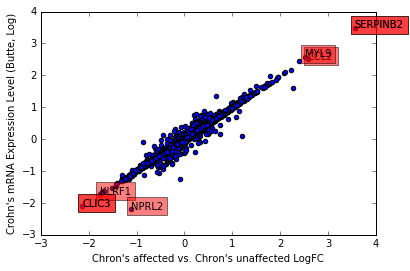

In [17]:
df_butte_GEO = diff_df.join(butte_entrez)
df_butte_GEO['log_butte_crohns'] = np.log2(df_butte_GEO['Crohns mRNA Expression Level'])
df_butte_GEO = df_butte_GEO[~pd.isnull(df_butte_GEO.index)]
df_butte_GEO=df_butte_GEO.dropna()
plt.scatter(df_butte_GEO.calc_fc,df_butte_GEO.log_butte_crohns)
plt.xlabel("Chron's affected vs. Chron's unaffected LogFC")
plt.ylabel("Crohn's mRNA Expression Level (Butte, Log)")
# label the top 4
for _,row in df_butte_GEO.sort("calc_fc").iloc[:2].iterrows():
    plt.text(row.calc_fc,row.log_butte_crohns,row.symbol,bbox=dict(facecolor='red', alpha=0.5))
for _,row in df_butte_GEO.sort("calc_fc").iloc[-2:].iterrows():
    plt.text(row.calc_fc,row.log_butte_crohns,row.symbol,bbox=dict(facecolor='red', alpha=0.5))
for _,row in df_butte_GEO.sort("log_butte_crohns").iloc[:2].iterrows():
    plt.text(row.calc_fc,row.log_butte_crohns,row.symbol,bbox=dict(facecolor='red', alpha=0.5))
for _,row in df_butte_GEO.sort("log_butte_crohns").iloc[-2:].iterrows():
    plt.text(row.calc_fc,row.log_butte_crohns,row.symbol,bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [24]:
#%%  load Connectivity map
pgm = pd.DataFrame.from_csv(os.path.join(BASE,"pgm.csv")) # probe-gene mapping
probe_gene = {row['probe_id']: row['symbol'] for gene,row in pgm.iterrows()}
drugs_df = pd.DataFrame.from_csv(os.path.join(BASE,"connmap/rankMatrix.txt"), sep='\t')
del drugs_df['Unnamed: 6101']
drugs_df = drugs_df[pd.notnull(drugs_df.index)]
drugs_df.index = [probe_gene.get(x,None) for x in drugs_df.index]

In [19]:
# get connectivity map ID -> drug name
cmap_meta = pd.read_csv(os.path.join(BASE,"connmap/cmap_instances_02.csv"))
cmap_id_name = {x["instance_id"]:x["cmap_name"] for _,x in cmap_meta.iterrows()}

In [20]:
drug = '915' # topiramate
genes_drug_rank = drugs_df[drug].groupby(level=0).mean().sort_values(inplace=False)
genes_drug_rank = {gene:n for n,gene in enumerate(genes_drug_rank.index)}
del drugs_df

In [22]:
#%% get Crohn's up/down genes using SAM
# SAM r file is 
up_df = pd.read_csv("/home/gstupp/projects/repositioning/GDS1615/SAM/up.csv")
up_df = up_df[up_df['q-value(%)']==0].sort('Fold Change',ascending=False)
up = list(up_df[up_df['Fold Change']>=2]['Gene ID'])

down_df = pd.read_csv("/home/gstupp/projects/repositioning/GDS1615/SAM/down.csv")
down_df = down_df[down_df['q-value(%)']==0].sort('Fold Change',ascending=True)
down = list(down_df[down_df['Fold Change']<=(1/2)]['Gene ID'])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [23]:
# Topiramate score:
DDS.calc_dds(genes_drug_rank, up, down)

0.3208387534668854

In [43]:
#%% Calculate score with all drugs in connn map version 1
dds = {}
for drug in tqdm(drugs_df.columns[:454]):
    genes_drug_rank = drugs_df[drug].groupby(level=0).mean().sort_values(inplace=False)
    genes_drug_rank = {gene:n for n,gene in enumerate(genes_drug_rank.index)}
    dds[drug] = DDS.calc_dds(genes_drug_rank, up, down)
    
dds2 = sorted([(x[0],abs(x[1])) for x in dds.items()], key=lambda x:x[1], reverse=True)
dds2 = sorted([(cmap_id_name[x[0]],x[1]) for x in dds.items()], key=lambda x:x[1], reverse=True)
result_df = pd.DataFrame(dds2)
result_df_mean=result_df.groupby(by=0).agg(['mean', 'count'])

100%|██████████| 454/454 [00:08<00:00, 53.33it/s]


In [44]:
print(result_df.sort_values(1,ascending=False).head())
print(result_df.sort_values(1,ascending=False).tail())

              0         1
0   splitomicin  0.344582
1   indometacin  0.344570
2  prednisolone  0.326249
3     estradiol  0.325987
4    topiramate  0.320839
                     0         1
449        resveratrol -0.417717
450         colchicine -0.418805
451          monastrol -0.420530
452   prochlorperazine -0.435796
453  tyrphostin AG-825 -0.446415


In [45]:
# average multiple profiles of the same drug together
print(result_df_mean.sort_values((1,"mean"),ascending=False).head())
print(result_df_mean.sort_values((1,"mean"),ascending=False).tail())

                        1      
                     mean count
0                              
splitomicin      0.344582     1
prednisolone     0.326249     1
topiramate       0.320839     1
amitriptyline    0.313250     1
fludrocortisone  0.283301     2
                          1      
                       mean count
0                                
5114445           -0.350860     1
exemestane        -0.374214     1
dexverapamil      -0.377207     1
mesalazine        -0.378033     1
tyrphostin AG-825 -0.446415     1


In [46]:
# run again with the full conn map
dds = {}
for drug in tqdm(drugs_df.columns):
    genes_drug_rank = drugs_df[drug].groupby(level=0).mean().sort_values(inplace=False)
    genes_drug_rank = {gene:n for n,gene in enumerate(genes_drug_rank.index)}
    dds[drug] = DDS.calc_dds(genes_drug_rank, up, down)
    
dds2 = sorted([(x[0],abs(x[1])) for x in dds.items()], key=lambda x:x[1], reverse=True)
dds2 = sorted([(cmap_id_name[x[0]],x[1]) for x in dds.items()], key=lambda x:x[1], reverse=True)
result_df = pd.DataFrame(dds2)
result_df_mean=result_df.groupby(by=0).agg(['mean', 'count'])

100%|██████████| 6100/6100 [01:56<00:00, 52.25it/s]


In [50]:
print(result_df.sort_values(1,ascending=False).head(50))
print(result_df.sort_values(1,ascending=False).tail())

                                 0         1
0                   betulinic acid  0.430129
1                 levopropoxyphene  0.403121
2                       ifosfamide  0.401337
3                      vinblastine  0.375004
4                        proguanil  0.373827
5                     0317956-0000  0.373762
6                        SR-95639A  0.369767
7                      pirenperone  0.368038
8                    trimethadione  0.363324
9                        tenoxicam  0.362751
10                   isoflupredone  0.360691
11                        levodopa  0.360236
12                    pioglitazone  0.358628
13                        benzamil  0.357380
14                    dioxybenzone  0.356115
15             isopropamide iodide  0.355858
16                chlorogenic acid  0.355447
17                 fludrocortisone  0.353795
18                  sulfaguanidine  0.353477
19                   Prestwick-642  0.353115
20                      nitrofural  0.350743
21        

In [48]:
# average multiple profiles of the same drug together
print(result_df_mean.sort_values((1,"mean"),ascending=False).head())
print(result_df_mean.sort_values((1,"mean"),ascending=False).tail())

                       1      
                    mean count
0                             
splitomicin     0.344582     1
topiramate      0.320839     1
spaglumic acid  0.311561     2
STOCK1N-35874   0.292172     2
U0125           0.272700     1
                          1      
                       mean count
0                                
dexverapamil      -0.377207     1
8-azaguanine      -0.398958     4
MS-275            -0.412111     2
menadione         -0.427211     2
tyrphostin AG-825 -0.446415     1
